In [53]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l1

import os

In [54]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion

In [55]:
#Axes to compare number of emotions per dataset
def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

In [56]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape:", data_X.shape, dataName, "_Y shape:", data_Y.shape)
    return data_X, data_Y

In [57]:
def plot_training(results):
    fig, axes = plt.subplots(1,2, figsize=(18, 6))
    # Plot training & validation accuracy values
    axes[0].plot(results.history['acc'])
    axes[0].plot(results.history['val_acc'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(results.history['loss'])
    axes[1].plot(results.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [58]:
##Functions

#Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [59]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# early stopping
es = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)

In [60]:
data = pd.read_csv('../Dataset/Dataset/FER2013/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [61]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [62]:
data['emotion'] = data['emotion'].rank(method='dense').astype(int) - 1

In [63]:
emotion_map = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6:'Surprise'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Neutral,6077
3,Surprise,6198
4,Happy,8989
5,Sad,4002
6,Disgust,547


In [64]:
data.shape

(35887, 3)

In [65]:
distinct_values = data['emotion'].unique()
distinct_values

array([0, 2, 4, 6, 3, 5, 1])

In [66]:
df = pd.read_csv('../Dataset/Dataset/CK+/ckextended.csv')
df.shape

(920, 3)

In [67]:
emotion_map = {0: 'Angry', 1:'Digust',2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral ', 7: 'Contempt'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Neutral,593
1,Happy,69
2,Contempt,18
3,Angry,45
4,Digust,59
5,Sad,28
6,Fear,25
7,Surprise,83


In [68]:
emotion_map = {0: 'Angry', 1:'Digust',2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral ', 7: 'Contempt'}
emotion_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

df = df[df['emotion'] != 7]
df['emotion'] = df['emotion'].map(emotion_mapping)
df['emotion'] = df['emotion'].fillna(np.nan)

df = df.reset_index(drop=True)

In [69]:
distinct_values = df['emotion'].unique()
distinct_values

array([6, 3, 0, 1, 4, 2, 5], dtype=int64)

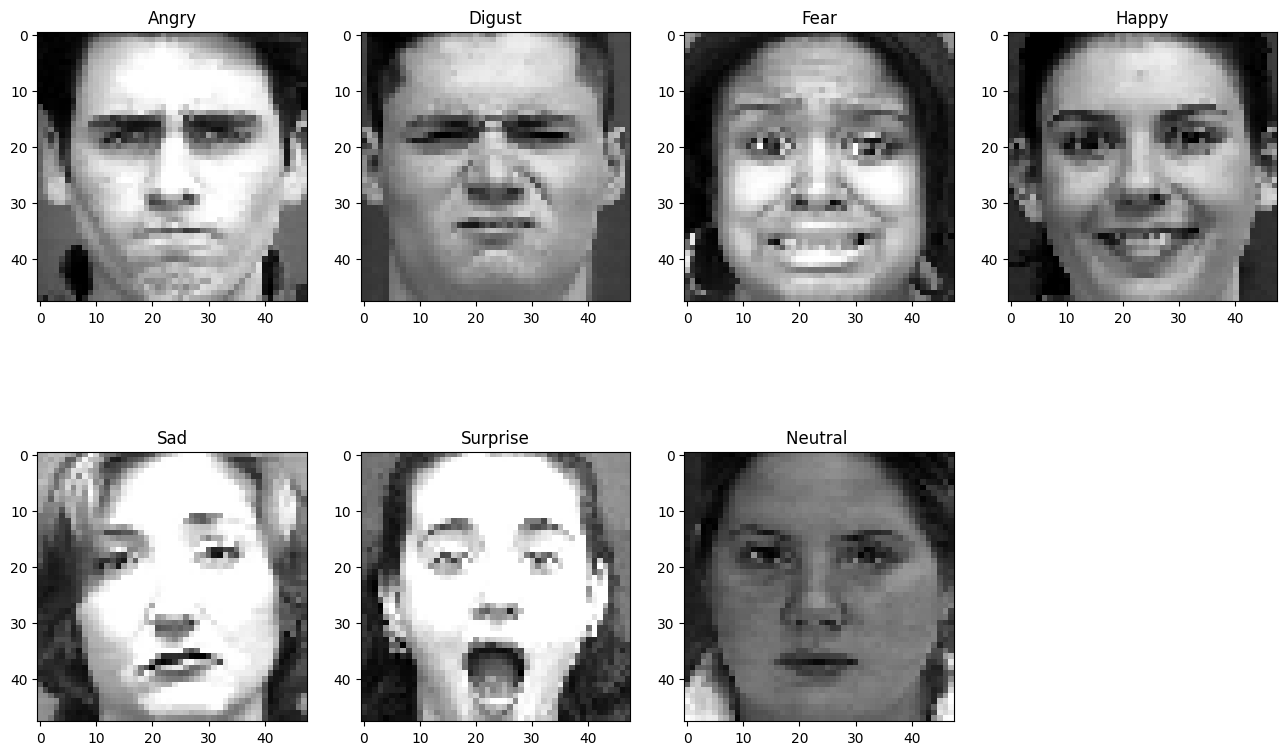

In [70]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [71]:
data_train = data[data['Usage']=='Training'].copy()
data_train = pd.concat([data_train, df], ignore_index=True)
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (29611, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [72]:
data_train.emotion.value_counts()

emotion
3    7284
6    5558
4    4858
2    4122
0    4040
5    3254
1     495
Name: count, dtype: int64

In [73]:
data_train = data_train[~data_train['emotion'].isin([1, 2, 5])] 
data_val = data_val[~data_val['emotion'].isin([1, 2, 5])] 
data_test = data_test[~data_test['emotion'].isin([1, 2, 5])] 

emotion_map = {0: 'Angry', 3: 'Happy', 4: 'Sad', 6: 'Neutral'}

emotion_mapping = {0: 0, 3: 1, 4: 2, 6: 3}

data_train['emotion'] = data_train['emotion'].map(emotion_mapping)
data_val['emotion'] = data_val['emotion'].map(emotion_mapping)
data_test['emotion'] = data_test['emotion'].map(emotion_mapping)

# print(data_train['emotion'].unique())  


In [74]:
def row3image(row, emotion_map):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion

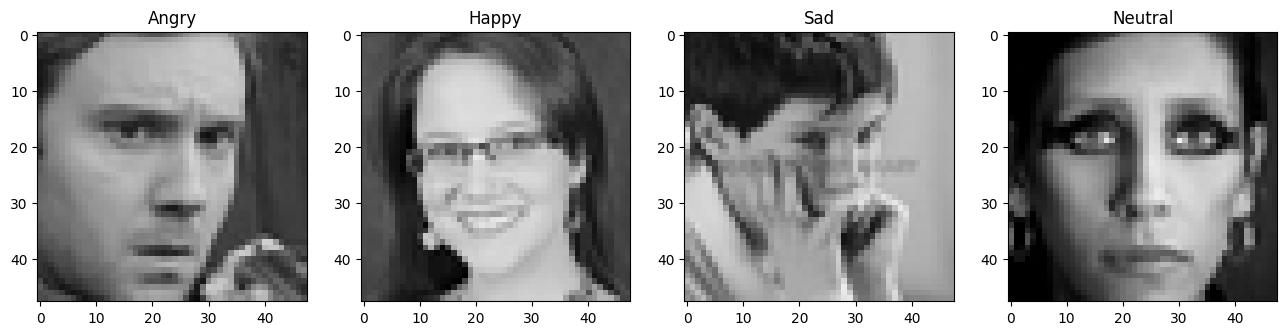

In [75]:
emotion_map = {0: 'Angry',  1: 'Happy', 2: 'Sad', 3: 'Neutral'}

plt.figure(0, figsize=(16,10))
for i in range(4):  # Adjust range to match emotion indices
    face = data_train[data_train['emotion'] == i].iloc[0]  # Use i directly without subtracting 1
    img = row3image(face, emotion_map)
    plt.subplot(2, 4, i+1)  # Increment i by 1 to start subplot index from 1
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

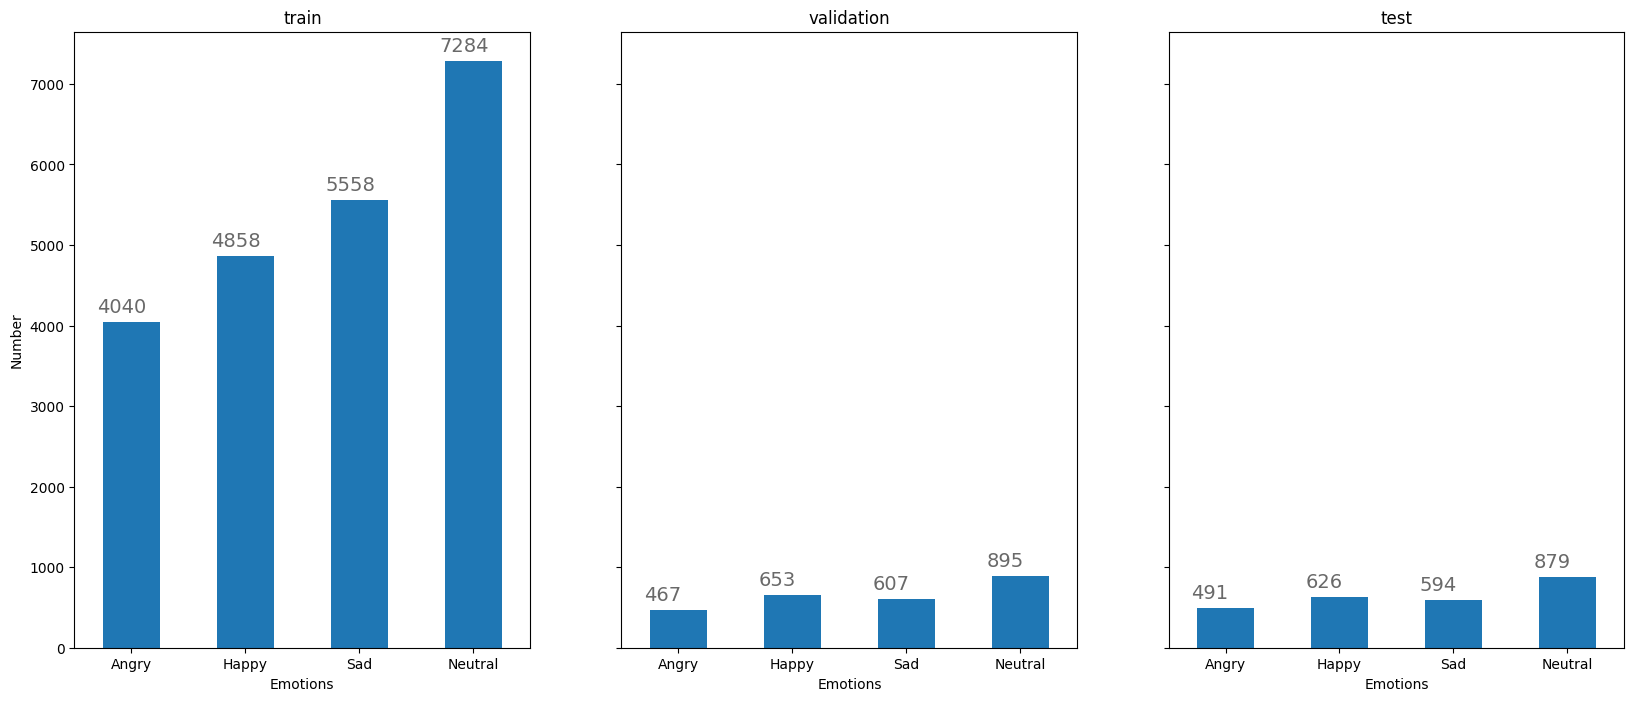

In [76]:
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [77]:
num_classes = 4
width, height = 48, 48
num_epochs = 100
batch_size = 32

train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: (21740, 48, 48, 1) train _Y shape: (21740, 4)
val _X shape: (2622, 48, 48, 1) val _Y shape: (2622, 4)
test _X shape: (2590, 48, 48, 1) test _Y shape: (2590, 4)


In [81]:
def build_grid_model(conv_1_filters, conv_2_filters, conv_3_filters, conv_4_filters,
                     conv_1_kernel, conv_2_kernel, conv_3_kernel, conv_4_kernel,
                     dropout_1, dropout_2, dropout_3, dense_units, l1_reg, optimizer, learning_rate):
    model = Sequential()

    # Module 1
    model.add(Conv2D(conv_1_filters, kernel_size=(conv_1_kernel, conv_1_kernel), input_shape=(48, 48, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_1_filters, kernel_size=(conv_1_kernel, conv_1_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(dropout_1))

    # Module 2
    model.add(Conv2D(conv_2_filters, kernel_size=(conv_2_kernel, conv_2_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_2_filters, kernel_size=(conv_2_kernel, conv_2_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Module 3
    model.add(Conv2D(conv_3_filters, kernel_size=(conv_3_kernel, conv_3_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_3_filters, kernel_size=(conv_3_kernel, conv_3_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_4_filters, kernel_size=(conv_4_kernel, conv_4_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(dropout_2))

    # Flatten
    model.add(Flatten())

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_3))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(4, activation='softmax'))  # Assuming 7 classes for the emotions

    # Choose the optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    else:
        opt = optimizer  # You can add more conditions for other optimizers

    # Compile the model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [85]:
import itertools

param_grid = {
    'conv_1_filters': [32, 64],
    'conv_2_filters': [64, 96, 128],
    'conv_3_filters': [128, 192, 224],
    'conv_4_filters': [128, 160, 224, 256],
    'conv_1_kernel': [3, 6, 8],
    'conv_2_kernel': [3, 5, 8],
    'conv_3_kernel': [3, 5, 8],
    'conv_4_kernel': [3, 5, 8],
    'dropout_1': [0.1, 0.2, 0.4],
    'dropout_2': [0.0, 0.2, 0.3],
    'dropout_3': [0.0, 0.2, 0.3, 0.4],
    'dense_units': [512, 768, 1024],
    'l1_reg': [0.01, 0.001, 0.0001],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [1e-2, 1e-3, 1e-4], 
    'epochs': [10, 50, 100]
}

def evaluate_model(params):
    fit_params = {k: params.pop(k) for k in ['epochs']}
    
    model = build_grid_model(**params)
    model.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                **fit_params,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))
    score = model.evaluate(val_X, val_Y, verbose=0)
    return score[1]

best_score = 0
best_params = None

for combo in itertools.product(*(param_grid[key] for key in param_grid)):
    params = dict(zip(param_grid.keys(), combo))
    accuracy = evaluate_model(params)
    print(f"{combo} done")
    if accuracy > best_score:
        best_score = accuracy
        best_params = params
        print("Best Score:", best_score)
        print("Best Params:", best_params)

Epoch 1/10
679/679 - 212s - loss: 38.3319 - accuracy: 0.3213 - val_loss: 29.4580 - val_accuracy: 0.3413 - 212s/epoch - 312ms/step
Epoch 2/10
679/679 - 235s - loss: 28.9317 - accuracy: 0.3346 - val_loss: 28.6676 - val_accuracy: 0.3413 - 235s/epoch - 345ms/step
Epoch 3/10
679/679 - 254s - loss: 28.6703 - accuracy: 0.3351 - val_loss: 28.6838 - val_accuracy: 0.3413 - 254s/epoch - 373ms/step
Epoch 4/10
679/679 - 240s - loss: 28.7074 - accuracy: 0.3351 - val_loss: 28.6800 - val_accuracy: 0.3413 - 240s/epoch - 354ms/step
Epoch 5/10
679/679 - 239s - loss: 28.7253 - accuracy: 0.3351 - val_loss: 28.7779 - val_accuracy: 0.3413 - 239s/epoch - 352ms/step
Epoch 6/10
679/679 - 233s - loss: 28.7220 - accuracy: 0.3351 - val_loss: 28.6997 - val_accuracy: 0.3413 - 233s/epoch - 343ms/step
(32, 64, 128, 128, 3, 3, 3, 3, 0.1, 0.0, 0.0, 512, 0.01, 'adam', 0.01, 10) done
Best Score: 0.3413424789905548
Best Params: {'conv_1_filters': 32, 'conv_2_filters': 64, 'conv_3_filters': 128, 'conv_4_filters': 128, 'conv

In [ ]:
#VGG-16 Model
model_1 = Sequential()

# Module 1
model_1.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 2
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 3
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model_1.add(Flatten())

# Dense layers
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

model_1.summary()

In [ ]:
history_1 = model_1.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_1.predict(test_X), axis=1)
vgg_16_score = accuracy_score(test_true, test_pred)
print("1.VGG-16 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_3 = Sequential()

# Initial Convolutional layer
model_3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.5))
    
model_3.add(Dense(num_classes, activation='softmax'))

model_3.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model_3.summary()

In [ ]:
history_3 = model_3.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=100,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_3.predict(test_X), axis=1)
improved_vgg_16_score = accuracy_score(test_true, test_pred)
print("3. Improved VGG-16 Inspired CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()